13:54:59 - cmdstanpy - INFO - compiling stan file /private/var/folders/qy/jsd9vfk56_zggrqsnvgyp9h40000gn/T/tmp02y9oo_a.stan to exe file /private/var/folders/qy/jsd9vfk56_zggrqsnvgyp9h40000gn/T/tmp02y9oo_a


Hit: 165, Miss: 35, FA: 33, CR: 167


13:55:13 - cmdstanpy - INFO - compiled model executable: /private/var/folders/qy/jsd9vfk56_zggrqsnvgyp9h40000gn/T/tmp02y9oo_a
13:55:13 - cmdstanpy - INFO - compiling stan file /private/var/folders/qy/jsd9vfk56_zggrqsnvgyp9h40000gn/T/tmp9yfy10zs.stan to exe file /private/var/folders/qy/jsd9vfk56_zggrqsnvgyp9h40000gn/T/tmp9yfy10zs
13:55:17 - cmdstanpy - INFO - compiled model executable: /private/var/folders/qy/jsd9vfk56_zggrqsnvgyp9h40000gn/T/tmp9yfy10zs
13:55:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


13:55:18 - cmdstanpy - INFO - CmdStan done processing.
13:55:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


13:55:18 - cmdstanpy - INFO - CmdStan done processing.




Parameter Estimates:
1HT: r = 0.781, g = 0.174
2HT: r = 0.599, d = 0.611, g = 0.497

Convergence:
1HT r_hat: r = 1.001, g = 1.001
2HT r_hat: r = 1.004, d = 1.006, g = 1.005

Model Performance:
Observed: Hit Rate = 0.825, FA Rate = 0.165
1HT Model: Hit Rate = 0.819, FA Rate = 0.174
2HT Model: Hit Rate = 0.822, FA Rate = 0.169


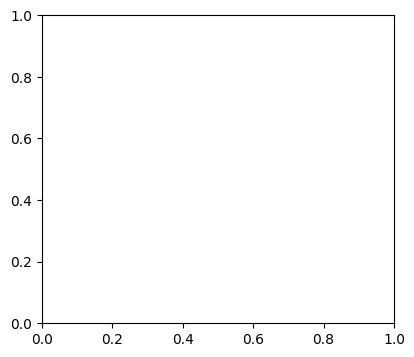

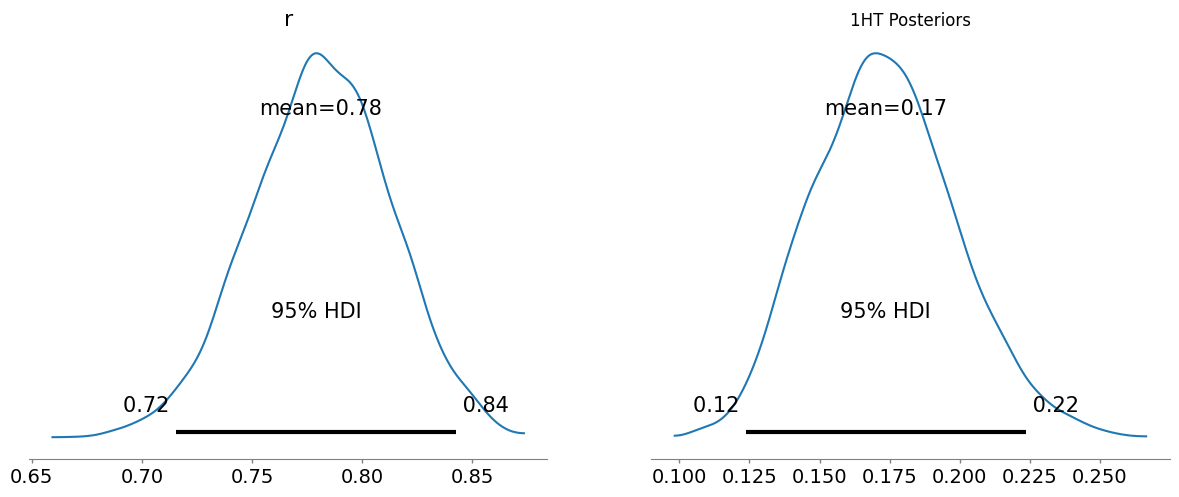

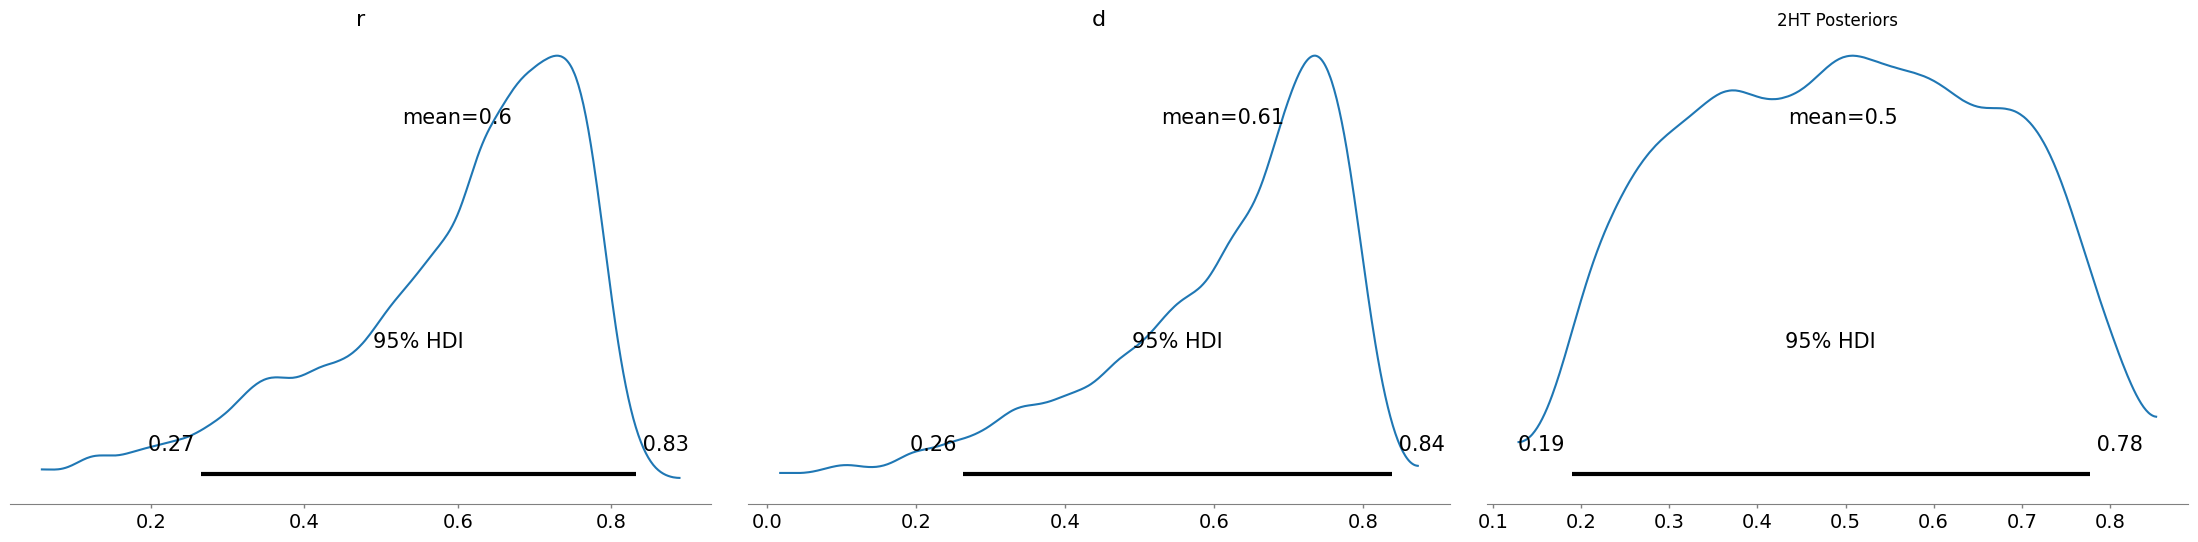

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from cmdstanpy import CmdStanModel
import os
import tempfile

np.random.seed(42)
responses = pd.DataFrame(columns=['word_type', 'response'])

for p in range(20):
    r, d, g = 0.7, 0.6, 0.5

    for i in range(10):
        if np.random.random() < r:
            response = 'yes'
        elif np.random.random() < g:
            response = 'yes'
        else:
            response = 'no'
        responses = pd.concat([responses, pd.DataFrame(
            {'word_type': ['old'], 'response': [response]})], ignore_index=True)

    for i in range(10):
        if np.random.random() < d:
            response = 'no'
        elif np.random.random() < g:
            response = 'yes'
        else:
            response = 'no'
        responses = pd.concat([responses, pd.DataFrame(
            {'word_type': ['new'], 'response': [response]})], ignore_index=True)

hit_count = len(responses[(responses['word_type'] == 'old') & (
    responses['response'] == 'yes')])
miss_count = len(
    responses[(responses['word_type'] == 'old') & (responses['response'] == 'no')])
fa_count = len(responses[(responses['word_type'] == 'new')
               & (responses['response'] == 'yes')])
cr_count = len(responses[(responses['word_type'] == 'new')
               & (responses['response'] == 'no')])

print(f"Hit: {hit_count}, Miss: {miss_count}, FA: {fa_count}, CR: {cr_count}")

one_ht_code = """
data {
  int<lower=0> hit_count;
  int<lower=0> miss_count;
  int<lower=0> fa_count;
  int<lower=0> cr_count;
}
parameters {
  real<lower=0, upper=1> r;
  real<lower=0, upper=1> g;
}
model {
  r ~ beta(2, 2);
  g ~ beta(2, 2);
  hit_count ~ binomial(hit_count + miss_count, r + (1-r)*g);
  fa_count ~ binomial(fa_count + cr_count, g);
}
generated quantities {
  real hit_prob = r + (1-r)*g;
  real fa_prob = g;
}
"""

two_ht_code = """
data {
  int<lower=0> hit_count;
  int<lower=0> miss_count;
  int<lower=0> fa_count;
  int<lower=0> cr_count;
}
parameters {
  real<lower=0, upper=1> r;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}
model {
  r ~ beta(2, 2);
  d ~ beta(2, 2);
  g ~ beta(2, 2);
  hit_count ~ binomial(hit_count + miss_count, r + (1-r)*g);
  fa_count ~ binomial(fa_count + cr_count, (1-d)*g);
}
generated quantities {
  real hit_prob = r + (1-r)*g;
  real fa_prob = (1-d)*g;
}
"""

with tempfile.NamedTemporaryFile(suffix='.stan', mode='w', delete=False) as f_1ht:
    f_1ht.write(one_ht_code)
    one_ht_file = f_1ht.name

with tempfile.NamedTemporaryFile(suffix='.stan', mode='w', delete=False) as f_2ht:
    f_2ht.write(two_ht_code)
    two_ht_file = f_2ht.name

try:
    one_ht_model = CmdStanModel(stan_file=one_ht_file)
    two_ht_model = CmdStanModel(stan_file=two_ht_file)

    stan_data = {
        'hit_count': hit_count,
        'miss_count': miss_count,
        'fa_count': fa_count,
        'cr_count': cr_count
    }

    one_ht_fit = one_ht_model.sample(
        data=stan_data, chains=4, iter_sampling=1000, iter_warmup=1000, seed=42)
    two_ht_fit = two_ht_model.sample(
        data=stan_data, chains=4, iter_sampling=1000, iter_warmup=1000, seed=42)

    one_ht_summary = one_ht_fit.summary()
    two_ht_summary = two_ht_fit.summary()

    print("\nParameter Estimates:")
    print(
        f"1HT: r = {one_ht_summary['Mean']['r']:.3f}, g = {one_ht_summary['Mean']['g']:.3f}")
    print(
        f"2HT: r = {two_ht_summary['Mean']['r']:.3f}, d = {two_ht_summary['Mean']['d']:.3f}, g = {two_ht_summary['Mean']['g']:.3f}")

    print("\nConvergence:")
    print(
        f"1HT r_hat: r = {one_ht_summary['R_hat']['r']:.3f}, g = {one_ht_summary['R_hat']['g']:.3f}")
    print(
        f"2HT r_hat: r = {two_ht_summary['R_hat']['r']:.3f}, d = {two_ht_summary['R_hat']['d']:.3f}, g = {two_ht_summary['R_hat']['g']:.3f}")

    observed_hit_rate = hit_count / (hit_count + miss_count)
    observed_fa_rate = fa_count / (fa_count + cr_count)
    pred_1ht_hit = one_ht_summary['Mean']['hit_prob']
    pred_1ht_fa = one_ht_summary['Mean']['fa_prob']
    pred_2ht_hit = two_ht_summary['Mean']['hit_prob']
    pred_2ht_fa = two_ht_summary['Mean']['fa_prob']

    print("\nModel Performance:")
    print(
        f"Observed: Hit Rate = {observed_hit_rate:.3f}, FA Rate = {observed_fa_rate:.3f}")
    print(
        f"1HT Model: Hit Rate = {pred_1ht_hit:.3f}, FA Rate = {pred_1ht_fa:.3f}")
    print(
        f"2HT Model: Hit Rate = {pred_2ht_hit:.3f}, FA Rate = {pred_2ht_fa:.3f}")

    az_one_ht = az.from_cmdstanpy(one_ht_fit)
    az_two_ht = az.from_cmdstanpy(two_ht_fit)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    az.plot_posterior(az_one_ht, var_names=['r', 'g'], hdi_prob=0.95)
    plt.title('1HT Posteriors')

    plt.subplot(1, 2, 2)
    az.plot_posterior(az_two_ht, var_names=['r', 'd', 'g'], hdi_prob=0.95)
    plt.title('2HT Posteriors')
    plt.tight_layout()
    plt.show()

finally:
    try:
        os.unlink(one_ht_file)
        os.unlink(two_ht_file)
    except:
        pass